In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# IA - Labyrinth

In [2]:
def generate_labyrinth(width, height, wall_ratio=0.3):
    """ Randomly generates the labyrinth matrix, the values are:
    0 if the cell is free
    1 if there is a wall
    :param width int: width of the matrix
    :param height int: height of the matrix
    :wall_ratio float: chance for a cell to be a wall
    :return: tuple composed of:
    <matrix>: numpy 2d array
    <start_cell>: tuple of i, j indices for the start cell
    <end_cell>: tuple of i, j indices for the end cell
    """
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [3]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    """ Display the labyrinth matrix and possibly the solution with matplotlib.
    Free cell will be in light gray.
    Wall cells will be in dark gray.
    Start and end cells will be in dark blue.
    Path cells (start, end excluded) will be in light blue.
    :param grid np.array: labyrinth matrix
    :param start_cell: tuple of i, j indices for the start cell
    :param end_cell: tuple of i, j indices for the end cell
    :param solution: list of successive tuple i, j indices who forms the path
    """
    grid = np.array(grid, copy=True)
    FREE_CELL = 19
    WALL_CELL = 16
    START = 0
    END = 0
    PATH = 2
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:-1]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [5]:
grid, start_cell, end_cell = generate_labyrinth(10, 10)

No solution has been found


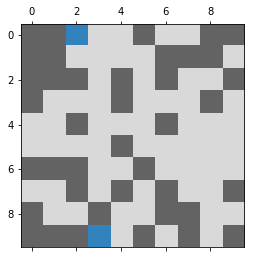

In [6]:
display_labyrinth(grid, start_cell, end_cell)